# Simple word recognition using dynamic time warping

A common problem in audio processing is speech recognition. In this post, we utilize dynamic time warping (DTW) to recognize a short phrase from a string of spoken words, also known as a "sentence" by humans. 

### DTW Overview

We choose to use dynamic time warping for this problem because of its ability to identify words spoken at different speeds, along with its simplicity. In particular, DTW is very good at matching two similar time-series multi-dimensional signals, which may be non-linearly shifted or warped: 


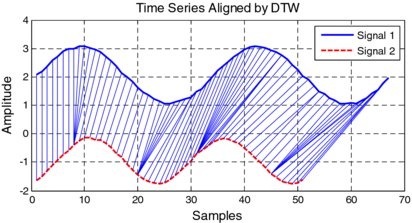

In [1]:
from IPython.display import Image
i = Image(filename='dtw_example.jpg')
i

The following is a very brief overview of DTW - I would refer you to the DTW wiki for more in-depth information. Dynamic warping produces a mapping function between signal 1 and signal 2, which maps each point from signal 1 with each point of signal 2. A key aspect of dynamic warping is the distance metric, which we define to be the exp(Euclidean distance). In this case, we use un-bounded DTW, which computes a distance between every single point of signal 1 with every point of signal 2:

In [2]:
#pseudocode
#for i in range(len(signal1)): 
#    for j in range(len(signal2)):
#        D[i+1, j+1] = dist(signal1[i], signal2[j])

Where D becomes a cost matrix between the two signals. Next a cumulative cost matrix is formed, beginning at [0,0] of D, and traversing the minimum cumulative cost path for each point up to each point in D, ending with the final point in D:

In [3]:
#pseudocode
#for i in range(len(signal1)):
#    for j in range(len(signal2)):
#        D[i+1, j+1] += min(D[i, j], D[i, j+1], D[i+1, j])

A cumulative cost matrix is formed, and we can compute the DTW distance betweeen signal 1 and signal 2 as D[len(signal1),len(signal2)], where D is now the cumulative cost matrix. In other words, we have computed the distance between the two signals, allowing for non-linear warping and differences in signal length. In addition, a mapping between each point of the two signals can be computed, but we pass over that aspect this time, as were are most interested in just the scalar distance value. 

### dtw.py

We use the dtw library from github.com/pierre-rouanet/dtw, the librosa package for audio analysis, numpy, matplotlib, and of course, iPython.

In [4]:
from dtw import dtw
import matplotlib.pyplot as plt
import numpy as np
import librosa
import IPython.display
from IPython.display import Image
%matplotlib inline

### Audio data preprocessing: Mel-frequency cepstrum coefficients (MFCCs)

Spoken words are recorded as time-series data:

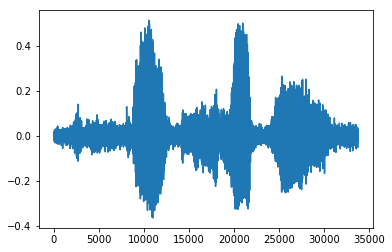

In [5]:
y, sr = librosa.load('audio_samples/chai_tea_latte_word.m4a')
plt.plot(y)
IPython.display.Audio(data=y, rate=sr)

But, in order to apply dynamic time warping it is important we pre-process the data, and in speech recognition applications, data are often represented using the mel-frequency cepstrum and a given time-series signal is represtented using its Mel-frequency cepstrum coefficients (MFCCs). According to Wikipedia, a main goal of utilizing the mel-frequency cepstrum is to represent the data in a way similar to how the human ear perceives sound. It's essentially a spectrum of a spectrum. Here is an example of the MFCCs of the audio of above:

In [7]:
mfcc = librosa.feature.mfcc(y, sr)
librosa.display.specshow(mfcc)

AttributeError: 'module' object has no attribute 'display'

### Applying DTW to audio data

###### Testing data

The problem is simple, to identify the phrase "Mother's Milk" (the title of the Red Hot Chili Pepper's fourth album), from a full sentence. The following is the test sentence, in which we would like to correctly identify the window in time containing the target phrase "Mother's Milk".  

In [8]:
yTest, srTest = librosa.load('audio_samples/elias_mothers_milk_sentence.m4a')
IPython.display.Audio(data=yTest, rate=srTest)

So this is the test sentence, and we would like to use training data in a lazy learning type fashion to identify our target word from the full setence.

###### Training data 

We need to assemble the training data. This is done by recording at least one instance of the target phrase. In this case, we use 3 different instances, from 3 speakers (2 male, 1 female) saying the phrase at roughly the same speed: 

In [9]:
y1, sr1 = librosa.load('audio_samples/elias_mothers_milk_word.m4a')
y2, sr2 = librosa.load('audio_samples/chris_mothers_milk_word.m4a')
y3, sr3 = librosa.load('audio_samples/yaoquan_mothers_milk_word.m4a')
IPython.display.Audio(data=y1, rate=sr1)

In [10]:
IPython.display.Audio(data=y2, rate=sr2)

In [11]:
IPython.display.Audio(data=y3, rate=sr3)

###### Create MFCC's

MFCC's are computed for both the training data and the test sentence, and we apply pre-processing to the MFCC's.

In [12]:
#Convert the data to mfcc:
mfcc1 = librosa.feature.mfcc(y1, sr1)
mfcc2 = librosa.feature.mfcc(y2, sr2)
mfcc3 = librosa.feature.mfcc(y3, sr3)
mfccTest = librosa.feature.mfcc(yTest,srTest)

# Remove mean and normalize each column of MFCC 
import copy
def preprocess_mfcc(mfcc):
    mfcc_cp = copy.deepcopy(mfcc)
    for i in xrange(mfcc.shape[1]):
        mfcc_cp[:,i] = mfcc[:,i] - np.mean(mfcc[:,i])
        mfcc_cp[:,i] = mfcc_cp[:,i]/np.max(np.abs(mfcc_cp[:,i]))
    return mfcc_cp

mfcc1 = preprocess_mfcc(mfcc1)
mfcc2 = preprocess_mfcc(mfcc2)
mfcc3 = preprocess_mfcc(mfcc3)
mfccTest = preprocess_mfcc(mfccTest)

### Word identification

Now that we have assembled our testing data and training data, we are ready to solve the problem. We window through the test sentence  using a window size equal to the length of the first training example (we use the this length somewhat arbitrarily). For each ith window we compute a DTW distance to the training data and we will select the window with the smallest distance to the trainig data. We elect to use exponential weighting as the similarity metric in DTW.

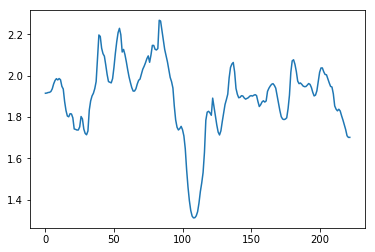

In [13]:
window_size = mfcc1.shape[1]
dists = np.zeros(mfccTest.shape[1] - window_size)

for i in range(len(dists)):
    mfcci = mfccTest[:,i:i+window_size]
    dist1i = dtw(mfcc1.T, mfcci.T,dist = lambda x, y: np.exp(np.linalg.norm(x - y, ord=1)))[0]
    dist2i = dtw(mfcc2.T, mfcci.T,dist = lambda x, y: np.exp(np.linalg.norm(x - y, ord=1)))[0]
    dist3i = dtw(mfcc3.T, mfcci.T,dist = lambda x, y: np.exp(np.linalg.norm(x - y, ord=1)))[0]
    dists[i] = (dist1i + dist2i + dist3i)/3
plt.plot(dists)

In [14]:
# select minimum distance window
word_match_idx = dists.argmin()
# convert MFCC to time domain
word_match_idx_bnds = np.array([word_match_idx,np.ceil(word_match_idx+window_size)])
samples_per_mfcc = 512
word_samp_bounds = (2/2) + (word_match_idx_bnds*samples_per_mfcc)

word = yTest[word_samp_bounds[0]:word_samp_bounds[1]]

TypeError: slice indices must be integers or None or have an __index__ method

In [15]:
IPython.display.Audio(data=word, rate=sr1)

NameError: name 'word' is not defined

Success! Our code correctly idenfies the target window, which contains the target phrase "Mother's Milk" from the sentence! In the plot above there is a clear minimum. In practice, we could implement a thresholding system to identify a specific word, given enough training data.


### Speaking faster

The previous example shows the power of DTW, but let's really test out the "warping", by trying to identify our target word from a sentence (also from a different speaker) spoken at a faster pace.

In [53]:
yTest, srTest = librosa.load('audio_samples/chris_mothers_milk_sentence_fast.m4a')
IPython.display.Audio(data=yTest, rate=srTest)

In [54]:
# create MFCC's and preprocess
mfccTest = librosa.feature.mfcc(yTest,srTest)
mfccTest = preprocess_mfcc(mfccTest)

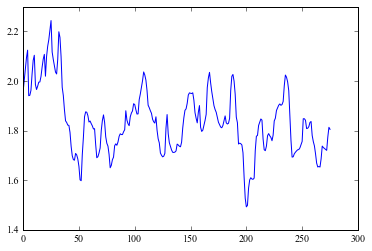

In [55]:
# same as before - window thru data
window_size = mfcc1.shape[1]*(1/2.) # use 1/2 window size
dists = np.zeros(mfccTest.shape[1] - window_size)

for i in range(len(dists)):
    mfcci = mfccTest[:,i:i+window_size]
    dist1i = dtw(mfcc1.T, mfcci.T,dist=lambda x, y: np.exp(np.linalg.norm(x - y, ord=1)))[0]
    dist2i = dtw(mfcc2.T, mfcci.T,dist=lambda x, y: np.exp(np.linalg.norm(x - y, ord=1)))[0]
    dist3i = dtw(mfcc3.T, mfcci.T)[0]
    dists[i] = (dist1i + dist2i + dist3i)/3
plt.plot(dists)

In [56]:
word_match_idx = dists.argmin()
word_match_idx_bnds = np.array([word_match_idx,np.ceil(word_match_idx+window_size)])
samples_per_mfcc = 512
word_samp_bounds = (2/2) + (word_match_idx_bnds*samples_per_mfcc)

word = yTest[word_samp_bounds[0]:word_samp_bounds[1]]

In [57]:
IPython.display.Audio(data=word, rate=sr1)

Again, success! We used the same training data, and identified the target phrase, only this time the target phrase was spoken much faster. This truly shows off the warping ability of DTW. 

A couple of notes:

We use 3 different speakers for the training data. While we've had success just using one speaker (not shown), I would guess using more speakers, particularly of different pitches makes the method more robust

For the second example where the speaker speaks faster, we forced the window to be smaller (2x smaller). While this isn't neccessary, it certainly makes the problem easier, and the result cleaner. In practice, you may have to use phonic analysis to identify exact windows 
    
Thanks for reading!!

Please forwards comments, suggestions, and questions to crawles/gmail